In [27]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("renewable_predicitons") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

In [28]:
path = 'hdfs://namenode:9000'
energy_edited = spark.read.csv(path + '/edata.csv', header=True, inferSchema=True)
energy = spark.read.csv(path + '/edatauc.csv', header=True, inferSchema=True)
df_weather = spark.read.csv(path + '/wdata.csv', header=True, inferSchema=True)

# Optional: Cache the DataFrames if you'll be using them multiple times
energy_edited.cache()
energy.cache()
df_weather.cache()

DataFrame[dt_iso: timestamp, city_name: string, temp: double, temp_min: double, temp_max: double, pressure: int, humidity: int, wind_speed: int, wind_deg: int, rain_1h: double, rain_3h: double, snow_3h: double, clouds_all: int, weather_id: int, weather_main: string, weather_description: string, weather_icon: string]

In [29]:
energy.show()

+-------------------+------------------+------------------------------------+----------------------------------+---------------------+---------------------------+---------------------+---------------------------+----------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+-----------------+------------------+----------------+--------------------------+----------------+----------------+------------------------+-----------------------+------------------------+-------------------------------+-------------------+-----------------+---------------+------------+
|               time|generation biomass|generation fossil brown coal/lignite|generation fossil coal-derived gas|generation fossil gas|generation fossil hard coal|generation fossil oil|generation fossil oil shale|generation fossil peat|generation geothermal|generation hydro pumped storage consumption|generation hydro run-of-river and

# Pre-processing

## Energy Preprocessing


In [30]:
columns_to_drop = ['generation fossil coal-derived gas', 'generation fossil oil shale',
                   'generation fossil peat', 'generation geothermal',
                   'generation hydro pumped storage aggregated', 'generation marine',
                   'generation wind offshore', 'forecast wind offshore eday ahead',
                   'total load forecast', 'forecast solar day ahead',
                   'forecast wind onshore day ahead']

energy = energy.drop(*columns_to_drop)
energy.printSchema()
print(f"Number of rows: {energy.count()}")
print(f"Number of columns: {len(energy.columns)}")


root
 |-- time: timestamp (nullable = true)
 |-- generation biomass: integer (nullable = true)
 |-- generation fossil brown coal/lignite: integer (nullable = true)
 |-- generation fossil gas: integer (nullable = true)
 |-- generation fossil hard coal: integer (nullable = true)
 |-- generation fossil oil: integer (nullable = true)
 |-- generation hydro pumped storage consumption: integer (nullable = true)
 |-- generation hydro run-of-river and poundage: integer (nullable = true)
 |-- generation hydro water reservoir: integer (nullable = true)
 |-- generation nuclear: integer (nullable = true)
 |-- generation other: integer (nullable = true)
 |-- generation other renewable: integer (nullable = true)
 |-- generation solar: integer (nullable = true)
 |-- generation waste: integer (nullable = true)
 |-- generation wind onshore: integer (nullable = true)
 |-- total load actual: integer (nullable = true)
 |-- price day ahead: double (nullable = true)
 |-- price actual: double (nullable = true

In [31]:
# Convert time to datetime and handle as timestamp column
from pyspark.sql.functions import col, to_timestamp, isnan, when, count, sum as spark_sum
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, lead, coalesce

In [32]:
# Convert time column to timestamp (equivalent to pd.to_datetime)
energy = energy.withColumn('time', to_timestamp(col('time')))

# Check for null values (equivalent to isnull().sum())
null_counts = energy.select([count(when(col(c).isNull(), c)).alias(c) for c in energy.columns])
null_counts.show()

+----+------------------+------------------------------------+---------------------+---------------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+------------------+----------------+--------------------------+----------------+----------------+-----------------------+-----------------+---------------+------------+
|time|generation biomass|generation fossil brown coal/lignite|generation fossil gas|generation fossil hard coal|generation fossil oil|generation hydro pumped storage consumption|generation hydro run-of-river and poundage|generation hydro water reservoir|generation nuclear|generation other|generation other renewable|generation solar|generation waste|generation wind onshore|total load actual|price day ahead|price actual|
+----+------------------+------------------------------------+---------------------+---------------------------+---------------------+--------------------

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_series_spark(df, column=None, ylabel=None, title=None, start=0, end=None):
    """
    Plot time series from Spark DataFrame
    Note: This converts to Pandas for plotting - use only for small datasets or samples
    """
    # Order by time and collect data
    df_ordered = df.orderBy('time')
    
    if end:
        df_sample = df_ordered.limit(end)
    else:
        df_sample = df_ordered
    
    # Convert to Pandas for plotting
    pdf = df_sample.toPandas()
    pdf = pdf.set_index('time')
    
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    
    if column and column in pdf.columns:
        ax.plot(pdf[column][start:end if end else len(pdf)])
        ax.set_ylabel(ylabel, fontsize=16)
    
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

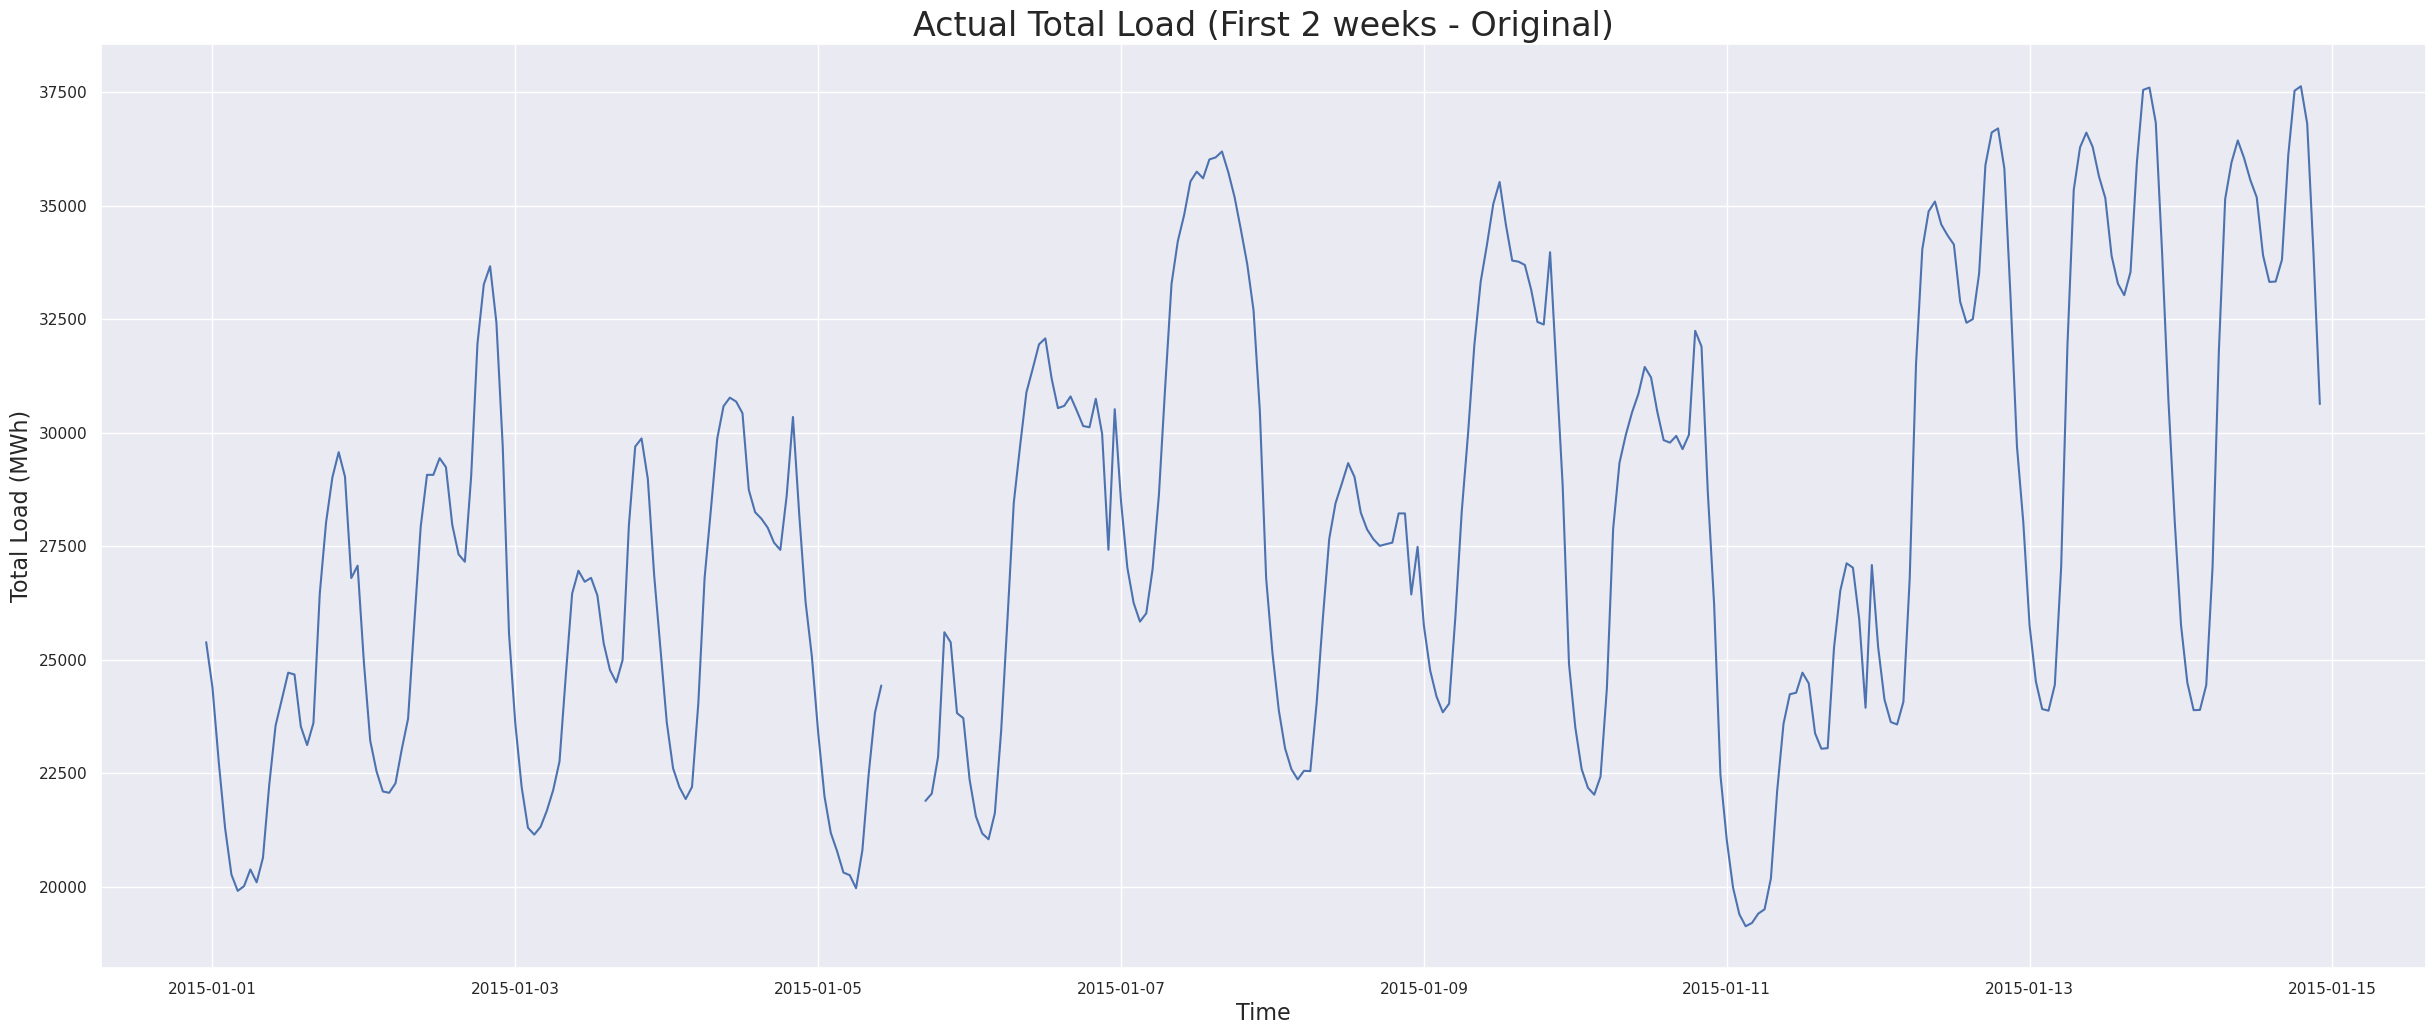

In [34]:
# Plot first 2 weeks of data (24*7*2 = 336 hours)
ax = plot_series_spark(df=energy, column='total load actual', 
                      ylabel='Total Load (MWh)',
                      title='Actual Total Load (First 2 weeks - Original)', 
                      end=336)
plt.show()

In [35]:
# # Fill null values using interpolation (Spark approach)
# # Note: Spark doesn't have direct interpolation like pandas, so we use window functions
# from pyspark.sql.functions import avg

# # Create window for interpolation
# window_spec = Window.orderBy('time').rowsBetween(-1, 1)

# # Apply interpolation to numeric columns (excluding time)
# numeric_cols = [col_name for col_name, col_type in energy.dtypes 
#                 if col_type in ['double', 'float', 'int', 'bigint'] and col_name != 'time']

# for col_name in numeric_cols:
#     energy = energy.withColumn(
#         col_name,
#         when(col(col_name).isNull(), 
#              avg(col(col_name)).over(window_spec)
#         ).otherwise(col(col_name))
#     )

In [36]:
# Fill nulls with mean values
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import col, when, count

# Get numeric columns (excluding time)
numeric_cols = [col_name for col_name, col_type in energy.dtypes 
                if col_type in ['double', 'float', 'int', 'bigint'] and col_name != 'time']

# Use Imputer to fill nulls with mean (keeping original column names)
imputer = Imputer(
    inputCols=numeric_cols,
    outputCols=numeric_cols,
    strategy="mean"
)

# Fit and transform
energy = imputer.fit(energy).transform(energy)

# Check null counts after filling
null_counts_after = energy.select([count(when(col(c).isNull(), c)).alias(c) for c in energy.columns])
print("Null counts after mean imputation:")
null_counts_after.show()

Null counts after mean imputation:
+----+------------------+------------------------------------+---------------------+---------------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+------------------+----------------+--------------------------+----------------+----------------+-----------------------+-----------------+---------------+------------+
|time|generation biomass|generation fossil brown coal/lignite|generation fossil gas|generation fossil hard coal|generation fossil oil|generation hydro pumped storage consumption|generation hydro run-of-river and poundage|generation hydro water reservoir|generation nuclear|generation other|generation other renewable|generation solar|generation waste|generation wind onshore|total load actual|price day ahead|price actual|
+----+------------------+------------------------------------+---------------------+---------------------------+-------

In [37]:
null_counts_after = energy.select([count(when(col(c).isNull(), c)).alias(c) for c in energy.columns])
print("Null counts after interpolation:")
null_counts_after.show()

Null counts after interpolation:
+----+------------------+------------------------------------+---------------------+---------------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+------------------+----------------+--------------------------+----------------+----------------+-----------------------+-----------------+---------------+------------+
|time|generation biomass|generation fossil brown coal/lignite|generation fossil gas|generation fossil hard coal|generation fossil oil|generation hydro pumped storage consumption|generation hydro run-of-river and poundage|generation hydro water reservoir|generation nuclear|generation other|generation other renewable|generation solar|generation waste|generation wind onshore|total load actual|price day ahead|price actual|
+----+------------------+------------------------------------+---------------------+---------------------------+---------

## Weather Preprocessing

In [38]:
df_weather.printSchema()
print(f"Number of rows: {df_weather.count()}")
print(f"Number of columns: {len(df_weather.columns)}")

root
 |-- dt_iso: timestamp (nullable = true)
 |-- city_name: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- pressure: integer (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- wind_speed: integer (nullable = true)
 |-- wind_deg: integer (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- rain_3h: double (nullable = true)
 |-- snow_3h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- weather_id: integer (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- weather_icon: string (nullable = true)

Number of rows: 178396
Number of columns: 17


In [39]:
# Convert integer columns to float (equivalent to df_convert_dtypes function)
from pyspark.sql.functions import col, to_timestamp, count, when, countDistinct
from pyspark.sql.types import FloatType

# Get integer columns and convert to float
integer_cols = [col_name for col_name, col_type in df_weather.dtypes 
                if col_type in ['int', 'bigint']]

for col_name in integer_cols:
    df_weather = df_weather.withColumn(col_name, col(col_name).cast(FloatType()))

# Convert dt_iso to datetime and create time column
df_weather = df_weather.withColumn('time', to_timestamp(col('dt_iso')))

# Drop dt_iso column
df_weather = df_weather.drop('dt_iso')

In [40]:
null_count = df_weather.select([count(when(col(c).isNull(), c)).alias(c) for c in df_weather.columns])
total_nulls = sum([df_weather.select(count(when(col(c).isNull(), c))).collect()[0][0] for c in df_weather.columns])
print(f'There are {total_nulls} missing values or NaNs in df_weather.')

# Check for duplicates
total_rows = df_weather.count()
distinct_rows = df_weather.distinct().count()
duplicates = total_rows - distinct_rows
print(f'There are {duplicates} duplicate rows in df_weather based on all columns.')

# Display energy observations count
energy_count = energy.count()
print(f'There are {energy_count} observations in df_energy.')

There are 0 missing values or NaNs in df_weather.
There are 21 duplicate rows in df_weather based on all columns.
There are 35064 observations in df_energy.


In [41]:
# Get unique cities and group by city
cities = df_weather.select('city_name').distinct().rdd.map(lambda x: x[0]).collect()

for city in cities:
    city_count = df_weather.filter(col('city_name') == city).count()
    print(f'There are {city_count} observations in df_weather about city: {city}.')

# Get unique weather descriptions
weather_descriptions = df_weather.select('weather_description').distinct().rdd.map(lambda x: x[0]).collect()
print("Unique weather descriptions:")
for desc in weather_descriptions:
    print(desc)

# Drop weather-related columns
columns_to_drop = ['weather_main', 'weather_id', 'weather_description', 'weather_icon']
df_weather = df_weather.drop(*columns_to_drop)

There are 36267 observations in df_weather about city: Madrid.
There are 35145 observations in df_weather about city: Valencia.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35951 observations in df_weather about city: Bilbao.
There are 35557 observations in df_weather about city: Seville.
Unique weather descriptions:
fog
drizzle
very heavy rain
proximity shower rain
few clouds
heavy intensity shower rain
haze
light rain
light intensity drizzle
light intensity shower rain
proximity thunderstorm
broken clouds
overcast clouds
light snow
scattered clouds
thunderstorm with rain
thunderstorm with heavy rain
heavy intensity drizzle
thunderstorm with light rain
heavy intensity rain
moderate rain
light intensity drizzle rain
sky is clear
shower rain
mist
thunderstorm
smoke
ragged shower rain
light thunderstorm
proximity moderate rain
shower sleet
sleet
rain and snow
light shower sleet
snow
light rain and snow
light shower snow
heavy snow
rain and drizzle
dust
pro

In [42]:
# Get weather columns (excluding city_name)
df_weather_cols = [col_name for col_name in df_weather.columns if col_name != 'city_name']
print("Weather columns (excluding city_name):")
print(df_weather_cols)

Weather columns (excluding city_name):
['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'time']


## Merging Datasets


In [43]:
# Group weather data by city and merge with energy data
from pyspark.sql.functions import col, count, when, regexp_replace

# Get unique cities
cities = df_weather.select('city_name').distinct().rdd.map(lambda x: x[0]).collect()

# Start with energy dataframe
df_final = energy

In [44]:
# Process each city separately
for city in cities:
    # Filter data for current city
    city_df = df_weather.filter(col('city_name') == city)
    
    # Clean city name for column suffix (remove spaces, quotes, brackets)
    city_str = city.replace(' ', '').replace("'", "").replace('[', '').replace(']', '')
    
    # Add suffix to all columns except time and city_name
    cols_to_rename = [c for c in city_df.columns if c not in ['time', 'city_name']]
    
    for old_col in cols_to_rename:
        city_df = city_df.withColumnRenamed(old_col, f"{old_col}_{city_str}")
    
    # Drop city_name column before merge
    city_df = city_df.drop('city_name')
    
    # Merge with main dataframe (outer join)
    df_final = df_final.join(city_df, on=['time'], how='outer')

# Display columns
print("Final dataframe columns:")
print(df_final.columns)

Final dataframe columns:
['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore', 'total load actual', 'price day ahead', 'price actual', 'temp_Madrid', 'temp_min_Madrid', 'temp_max_Madrid', 'pressure_Madrid', 'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid', 'rain_1h_Madrid', 'rain_3h_Madrid', 'snow_3h_Madrid', 'clouds_all_Madrid', 'temp_Valencia', 'temp_min_Valencia', 'temp_max_Valencia', 'pressure_Valencia', 'humidity_Valencia', 'wind_speed_Valencia', 'wind_deg_Valencia', 'rain_1h_Valencia', 'rain_3h_Valencia', 'snow_3h_Valencia', 'clouds_all_Valencia', 'temp_Barcelona', 'temp_min_Barcelona', 'temp_max_Barcelona', 'pr

In [45]:
# Check for missing values
total_nulls = sum([df_final.select(count(when(col(c).isNull(), c))).collect()[0][0] for c in df_final.columns])
print(f'There are {total_nulls} missing values or NaNs in df_final.')

# Check for duplicates
total_rows = df_final.count()
distinct_rows = df_final.distinct().count()
duplicates = total_rows - distinct_rows
print(f'\nThere are {duplicates} duplicate rows in df_final based on all columns.')

# Display schema info
df_final.printSchema()
print(f"Number of rows: {df_final.count()}")
print(f"Number of columns: {len(df_final.columns)}")

# Drop rain_3h columns for specific cities
cities_list = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities_list:
    rain_col = f'rain_3h_{city}'
    if rain_col in df_final.columns:
        df_final = df_final.drop(rain_col)

There are 0 missing values or NaNs in df_final.

There are 3504 duplicate rows in df_final based on all columns.
root
 |-- time: timestamp (nullable = true)
 |-- generation biomass: integer (nullable = true)
 |-- generation fossil brown coal/lignite: integer (nullable = true)
 |-- generation fossil gas: integer (nullable = true)
 |-- generation fossil hard coal: integer (nullable = true)
 |-- generation fossil oil: integer (nullable = true)
 |-- generation hydro pumped storage consumption: integer (nullable = true)
 |-- generation hydro run-of-river and poundage: integer (nullable = true)
 |-- generation hydro water reservoir: integer (nullable = true)
 |-- generation nuclear: integer (nullable = true)
 |-- generation other: integer (nullable = true)
 |-- generation other renewable: integer (nullable = true)
 |-- generation solar: integer (nullable = true)
 |-- generation waste: integer (nullable = true)
 |-- generation wind onshore: integer (nullable = true)
 |-- total load actual: in

In [46]:
# Final dataframe
df = df_final
# To show top 5 rows in PySpark
df.show(5)

# df1 = df_final.coalesce(1)
# df1.coalesce(1).write.csv("file:///home/jovyan/work/finalmerged.csv", header=True, mode='overwrite')


+-------------------+------------------+------------------------------------+---------------------+---------------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+------------------+----------------+--------------------------+----------------+----------------+-----------------------+-----------------+---------------+------------+------------+---------------+---------------+---------------+---------------+-----------------+---------------+--------------+--------------+-----------------+-------------+-----------------+-----------------+-----------------+-----------------+-------------------+-----------------+----------------+----------------+-------------------+--------------+------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-----------------+--------------------+------------+---------------+---------

In [47]:
# Create energy distribution dataframe by dropping specific columns
columns_to_drop = ['total load actual', 'price day ahead', 'price actual']
energy_graph_distribution = energy.drop(*columns_to_drop)

# Display schema info
energy_graph_distribution.printSchema()
print(f"Number of rows: {energy_graph_distribution.count()}")
print(f"Number of columns: {len(energy_graph_distribution.columns)}")

root
 |-- time: timestamp (nullable = true)
 |-- generation biomass: integer (nullable = true)
 |-- generation fossil brown coal/lignite: integer (nullable = true)
 |-- generation fossil gas: integer (nullable = true)
 |-- generation fossil hard coal: integer (nullable = true)
 |-- generation fossil oil: integer (nullable = true)
 |-- generation hydro pumped storage consumption: integer (nullable = true)
 |-- generation hydro run-of-river and poundage: integer (nullable = true)
 |-- generation hydro water reservoir: integer (nullable = true)
 |-- generation nuclear: integer (nullable = true)
 |-- generation other: integer (nullable = true)
 |-- generation other renewable: integer (nullable = true)
 |-- generation solar: integer (nullable = true)
 |-- generation waste: integer (nullable = true)
 |-- generation wind onshore: integer (nullable = true)

Number of rows: 35064
Number of columns: 15


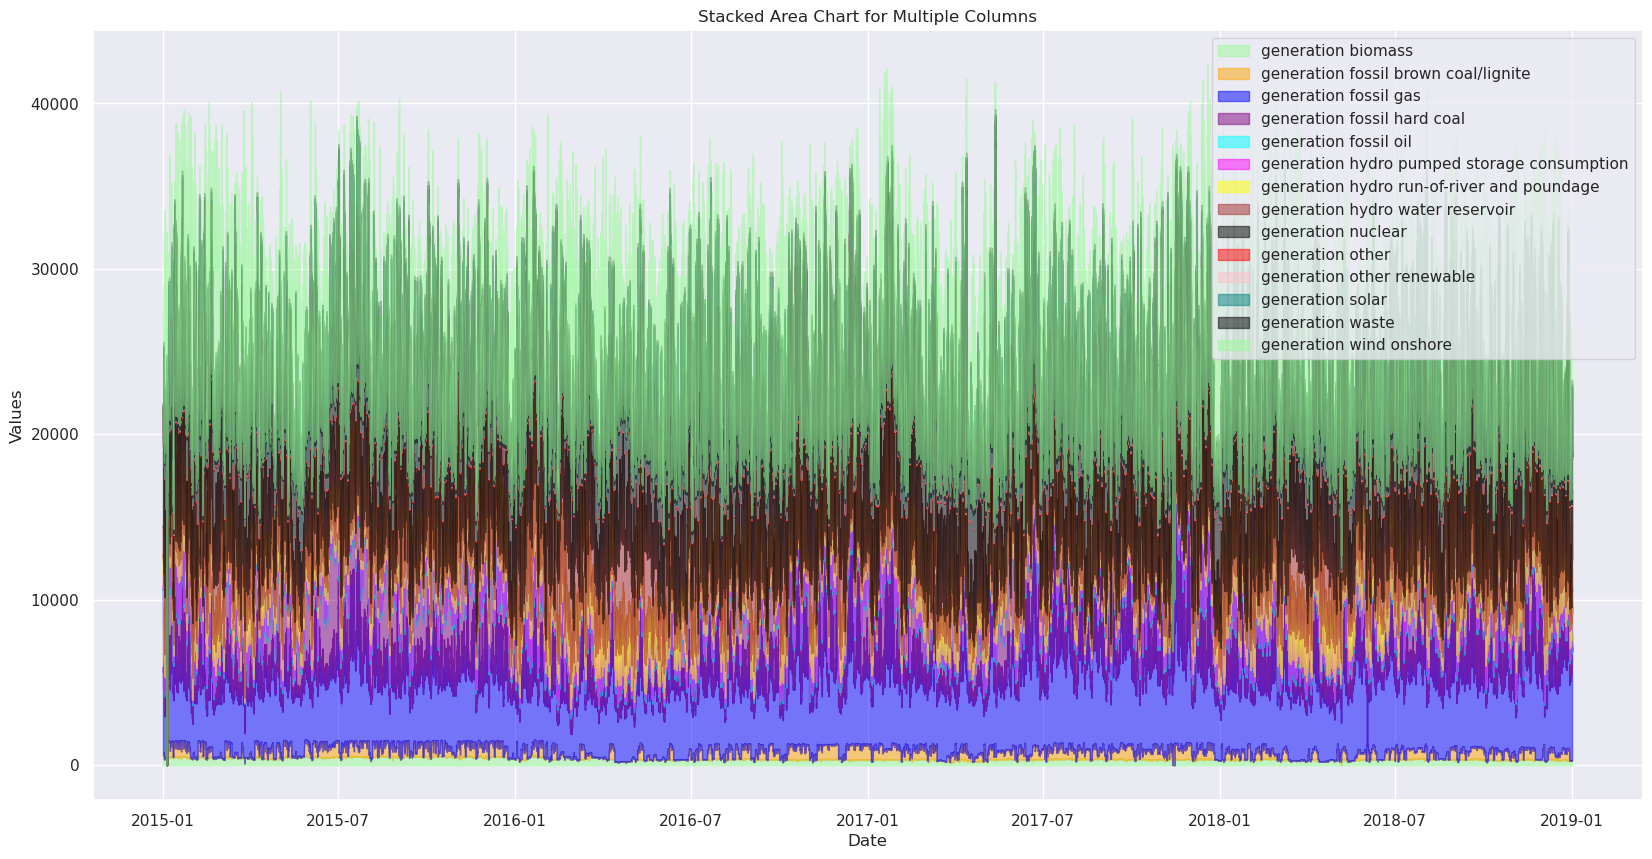

In [48]:
# For plotting, convert to Pandas (use with caution for large datasets)
# Consider sampling for large datasets: energy_graph_distribution.sample(0.1)
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas for plotting
pdf = energy_graph_distribution.orderBy('time').toPandas()
pdf = pdf.set_index('time')

# Define colors
colors = [
    'palegreen', 'orange', 'blue', 'purple', 'cyan', 'magenta', 'yellow',
    'brown', 'black', 'red', 'pink', 'teal', 'black'
]

plt.figure(figsize=(20, 10))

# Initialize a baseline series with zeros
baseline = pd.Series(0, index=pdf.index)

# Create stacked area chart
for i, column in enumerate(pdf.columns):
    plt.fill_between(pdf.index, baseline, baseline + pdf[column], 
                    label=column, alpha=0.5, color=colors[i % len(colors)])
    baseline += pdf[column]

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Stacked Area Chart for Multiple Columns')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
energy.show()

+-------------------+------------------+------------------------------------+---------------------+---------------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+------------------+----------------+--------------------------+----------------+----------------+-----------------------+-----------------+---------------+------------+
|               time|generation biomass|generation fossil brown coal/lignite|generation fossil gas|generation fossil hard coal|generation fossil oil|generation hydro pumped storage consumption|generation hydro run-of-river and poundage|generation hydro water reservoir|generation nuclear|generation other|generation other renewable|generation solar|generation waste|generation wind onshore|total load actual|price day ahead|price actual|
+-------------------+------------------+------------------------------------+---------------------+-------------------------

# Modelling


## Prophet Model for Load Actual

In [26]:
## Run this if prophet is not installed
# !pip install prophet
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 2.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.2/365.2 kB 1.7 MB/s eta 0:00:0000:0100:01


In [50]:
# Prophet model for 'total load actual' column
from prophet import Prophet
import pandas as pd
from pyspark.sql.functions import col

# Select only time and total load actual columns
prophet_data = energy.select('time', 'total load actual')

# Convert to Pandas for Prophet (Prophet requires pandas DataFrame)
prophet_df = prophet_data.orderBy('time').toPandas()

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_df = prophet_df.rename(columns={'time': 'ds', 'total load actual': 'y'})

# Remove any remaining null values
prophet_df = prophet_df.dropna()

# Display data info
print(f"Data shape: {prophet_df.shape}")
print(f"Date range: {prophet_df['ds'].min()} to {prophet_df['ds'].max()}")
print(f"First few rows:")
print(prophet_df.head())

Data shape: (35064, 2)
Date range: 2014-12-31 23:00:00 to 2018-12-31 22:00:00
First few rows:
                   ds      y
0 2014-12-31 23:00:00  25385
1 2015-01-01 00:00:00  24382
2 2015-01-01 01:00:00  22734
3 2015-01-01 02:00:00  21286
4 2015-01-01 03:00:00  20264


In [51]:
# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative',  # or 'additive'
    changepoint_prior_scale=0.05
)

# Fit the model
print("Fitting Prophet model...")
model.fit(prophet_df)

# Create future dataframe for forecasting
# Forecast for next 30 days (720 hours)
future = model.make_future_dataframe(periods=720, freq='H')  # hourly frequency

# Make predictions
print("Making predictions...")
forecast = model.predict(future)


Fitting Prophet model...


09:02:47 - cmdstanpy - INFO - Chain [1] start processing
09:03:05 - cmdstanpy - INFO - Chain [1] done processing


Making predictions...



Forecast columns:
['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'daily', 'daily_lower', 'daily_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'yhat']

Forecast shape: (35784, 22)

Last few predictions:
                       ds          yhat    yhat_lower    yhat_upper
35774 2019-01-30 13:00:00  34360.324700  30652.519051  37675.765489
35775 2019-01-30 14:00:00  33643.343248  30056.103002  37038.331844
35776 2019-01-30 15:00:00  33201.270334  29715.241915  36674.260509
35777 2019-01-30 16:00:00  33399.479366  29750.814035  36844.032888
35778 2019-01-30 17:00:00  34194.704414  30880.067990  37685.392055
35779 2019-01-30 18:00:00  35038.887701  31693.094343  38572.432085
35780 2019-01-30 19:00:00  35199.845065  31689.752763  38563.330424
35781 2019-01-30 20:00:00  342

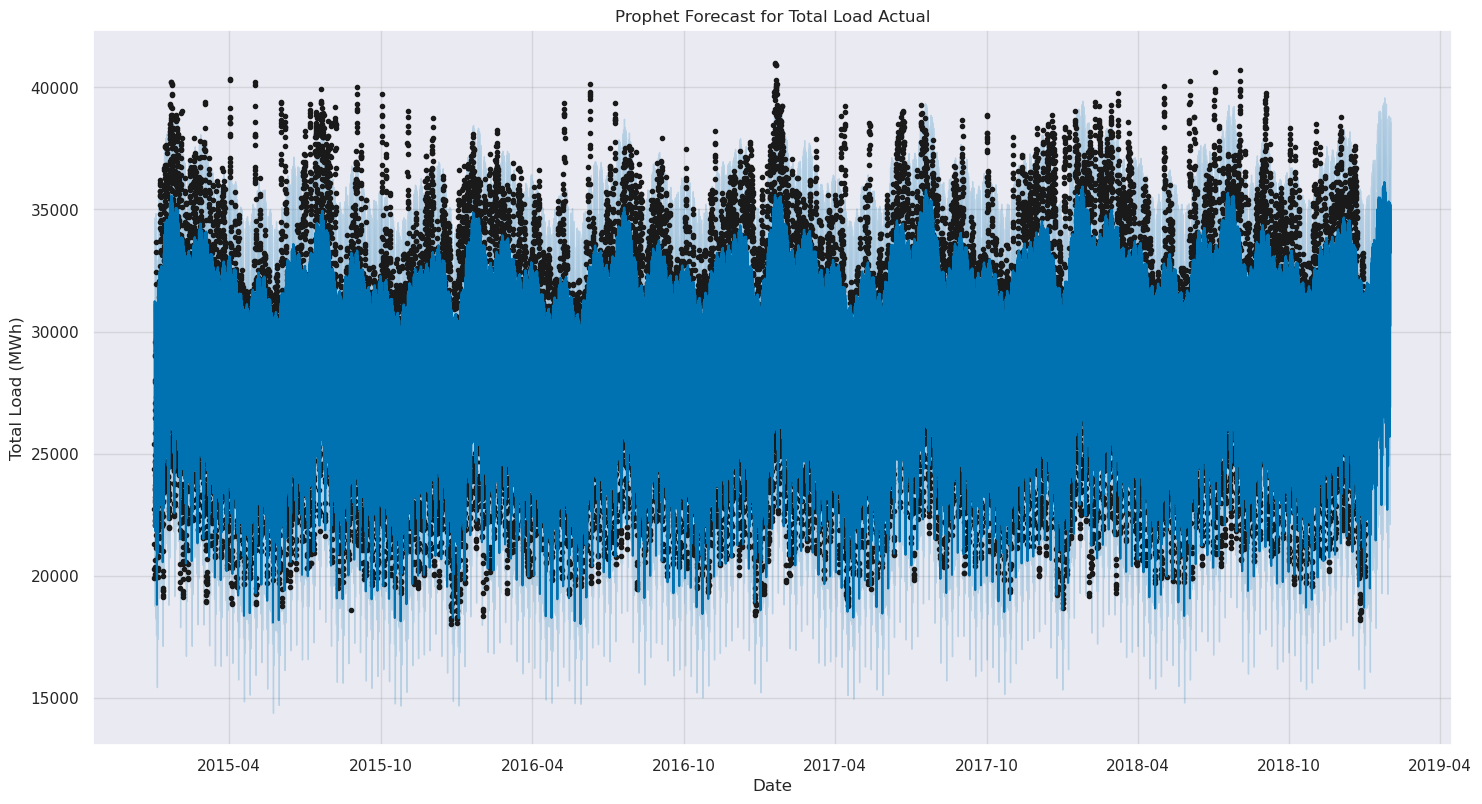

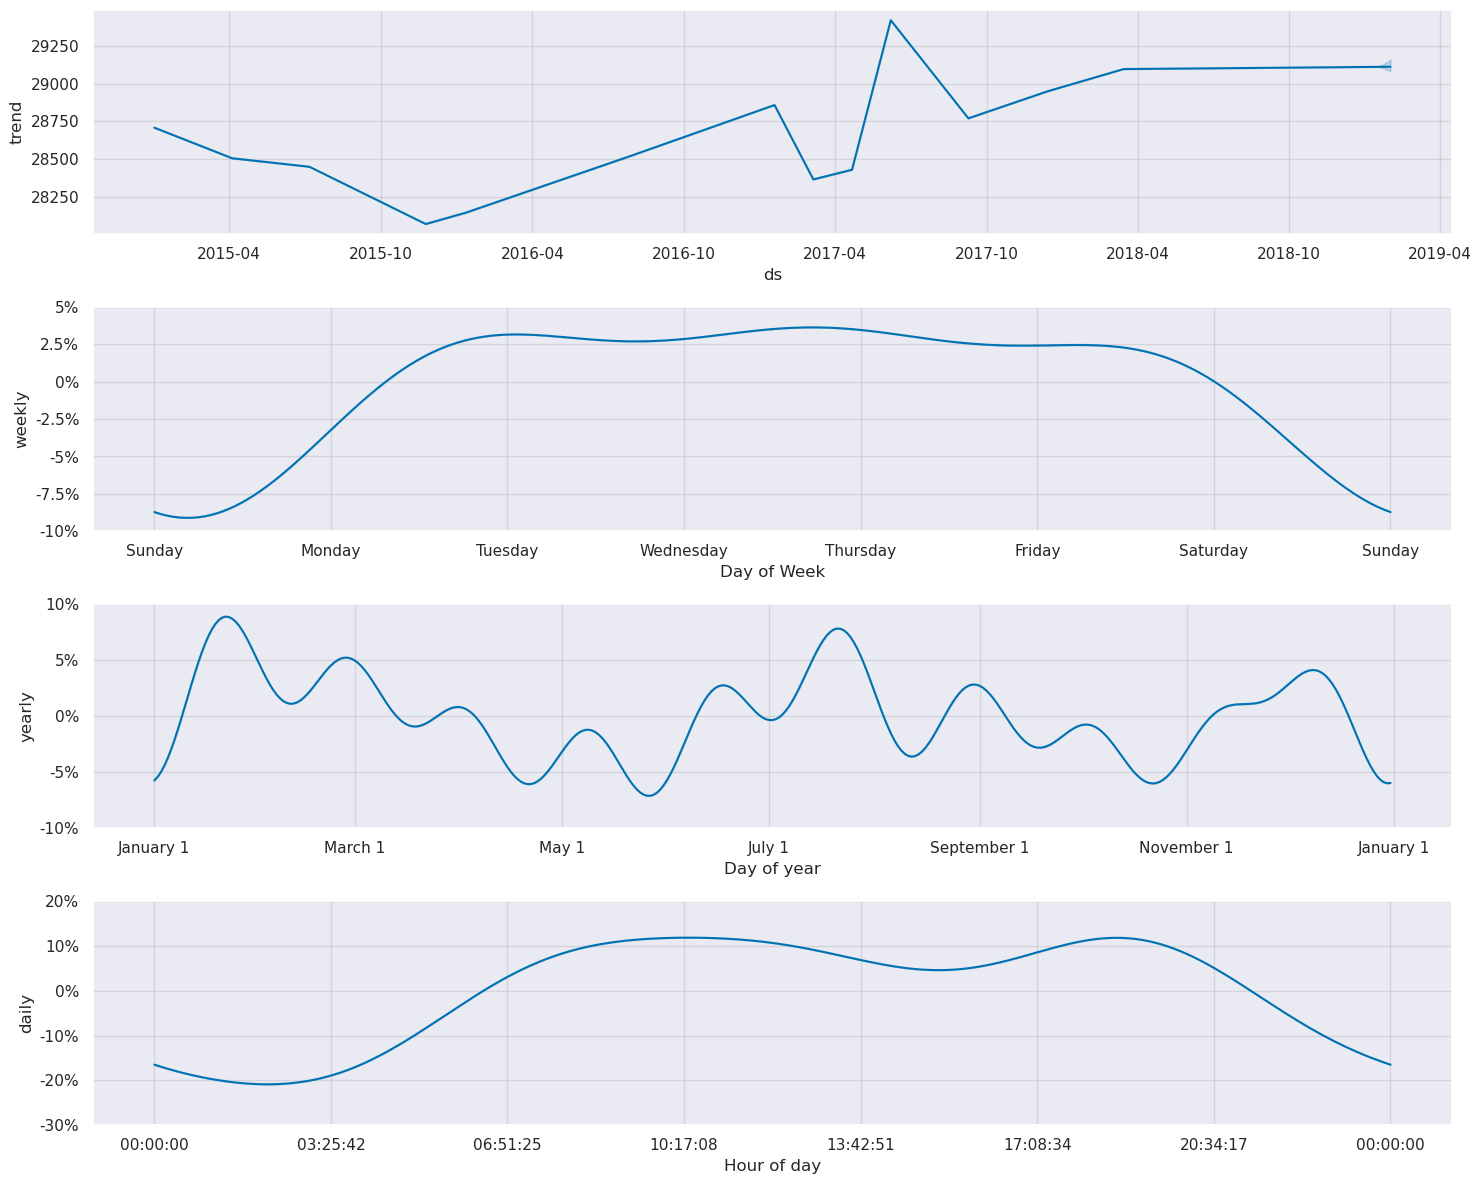


Model Performance Metrics:
MAE: 2009.92
RMSE: 2680.98
MAPE: 7.15%


In [52]:
# Display forecast results
print("\nForecast columns:")
print(forecast.columns.tolist())
print(f"\nForecast shape: {forecast.shape}")
print(f"\nLast few predictions:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# Plot the forecast
import matplotlib.pyplot as plt

# Plot forecast
fig1 = model.plot(forecast, figsize=(15, 8))
plt.title('Prophet Forecast for Total Load Actual')
plt.xlabel('Date')
plt.ylabel('Total Load (MWh)')
plt.show()

# Plot components
fig2 = model.plot_components(forecast, figsize=(15, 12))
plt.show()

# Calculate and display model performance metrics on training data
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get predictions for training period
train_predictions = forecast[forecast['ds'] <= prophet_df['ds'].max()]
train_predictions = train_predictions.merge(prophet_df, on='ds', how='inner')

mae = mean_absolute_error(train_predictions['y'], train_predictions['yhat'])
rmse = np.sqrt(mean_squared_error(train_predictions['y'], train_predictions['yhat']))
mape = np.mean(np.abs((train_predictions['y'] - train_predictions['yhat']) / train_predictions['y'])) * 100

print(f"\nModel Performance Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

In [53]:
# !pip install joblib
import joblib
# --- 3. Define the filename for saving your model ---
# It's common practice to use a .joblib or .pkl extension for joblib/pickle files.
model_filename = 'prophet_model.joblib'

# --- 4. Save the trained Prophet model using joblib ---
# joblib.dump() serializes the Python object (your Prophet model)
# into a file, making it ready to be loaded later.
print(f"Saving Prophet model to: '{model_filename}'...")
try:
    joblib.dump(model, model_filename)
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving model: {e}")
print("-" * 30)

Saving Prophet model to: 'prophet_model.joblib'...
Model saved successfully!
------------------------------


In [54]:
print(f"Attempting to load Prophet model from: '{model_filename}'...")
loaded_model = None
try:
    # Ensure 'joblib' is imported and available in the current scope.
    loaded_model = joblib.load(model_filename)
    print("Model loaded successfully!")
    print(f"Type of loaded object: {type(loaded_model)}")

    # You can now use the loaded_model to make predictions or further analysis
    # For example, let's make a future dataframe and predict with the loaded model
    future_loaded = loaded_model.make_future_dataframe(periods=5, freq='H')
    forecast_loaded = loaded_model.predict(future_loaded)
    print("\nFirst few predictions from the loaded model:")
    print(forecast_loaded[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

except FileNotFoundError:
    print(f"Error: Model file '{model_filename}' not found. Make sure it was saved correctly in step 4.")
except NameError:
    print("Error: 'joblib' is not defined when attempting to load. Please ensure 'import joblib' is at the top of your script/cell and executed.")
except Exception as e:
    print(f"An unexpected error occurred while loading the model: {e}")
print("-" * 30)

Attempting to load Prophet model from: 'prophet_model.joblib'...
Model loaded successfully!
Type of loaded object: <class 'prophet.forecaster.Prophet'>

First few predictions from the loaded model:
                   ds          yhat    yhat_lower    yhat_upper
0 2014-12-31 23:00:00  24650.996703  21369.525354  28125.123001
1 2015-01-01 00:00:00  23292.002581  19691.706501  26468.381911
2 2015-01-01 01:00:00  22423.924269  19160.401507  25880.829052
3 2015-01-01 02:00:00  22018.837248  18248.119498  25279.267761
4 2015-01-01 03:00:00  22219.139888  18776.534111  25691.403895
------------------------------


## Renewable Energy

In [56]:
# --- Solar and Wind Onshore Generation Prediction Models ---

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Convert Spark DataFrame to pandas if not already
df_pd = df.toPandas() if not isinstance(df, pd.DataFrame) else df.copy()

# Drop rows with missing target values
df_pd = df_pd.dropna(subset=['generation solar', 'generation wind onshore'])

# Select relevant features (adjust as needed based on your columns)
feature_cols = [
    # 'forecast solar day ahead', 'forecast wind onshore day ahead',
    'temp_Madrid', 'temp_min_Madrid', 'temp_max_Madrid', 'pressure_Madrid', 'humidity_Madrid', 'wind_speed_Madrid',
    'temp_Valencia', 'temp_min_Valencia', 'temp_max_Valencia', 'pressure_Valencia', 'humidity_Valencia', 'wind_speed_Valencia',
    'temp_Barcelona', 'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelona',
    'temp_Bilbao', 'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao', 'wind_speed_Bilbao',
    'temp_Seville', 'temp_min_Seville', 'temp_max_Seville', 'pressure_Seville', 'humidity_Seville', 'wind_speed_Seville',
]

# Drop rows with missing feature values
df_pd = df_pd.dropna(subset=feature_cols)

results = {}

for target in ['generation solar', 'generation wind onshore']:
    X = df_pd[feature_cols]
    y = df_pd[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

    # Ridge Regression
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

    results[target] = {
        'RandomForest': {'MAE': mae_rf, 'RMSE': rmse_rf},
        'Ridge': {'MAE': mae_ridge, 'RMSE': rmse_ridge}
    }

# Display results
for target, res in results.items():
    print(f"\nResults for {target}:")
    for model, metrics in res.items():
        print(f"  {model}: MAE = {metrics['MAE']:.2f}, RMSE = {metrics['RMSE']:.2f}")


Results for generation solar:
  RandomForest: MAE = 604.49, RMSE = 882.28
  Ridge: MAE = 974.06, RMSE = 1256.28

Results for generation wind onshore:
  RandomForest: MAE = 1376.99, RMSE = 1931.81
  Ridge: MAE = 2329.17, RMSE = 2953.88


In [65]:
#Agent
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, dayofweek, month, col, to_timestamp
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Start Spark session
spark = SparkSession.builder.getOrCreate()

# Read CSV from HDFS
df = spark.read.csv(path+"/rmod.csv", header=True, inferSchema=True)

# Parse time column and extract features
df = df.withColumn("time", to_timestamp(col("time")))
df = df.withColumn("hour", hour(col("time")))
df = df.withColumn("dayofweek", dayofweek(col("time")))  # Spark: 1=Sunday, 7=Saturday
df = df.withColumn("month", month(col("time")))

# Drop rows with missing values in relevant columns
for c in ["generation solar", "generation wind onshore", "forecast solar day ahead", "forecast wind onshore day ahead"]:
    df = df.filter(col(c).isNotNull())

# Select features and convert to pandas
feature_cols = [
    "forecast solar day ahead", "forecast wind onshore day ahead",
    "hour", "dayofweek", "month"
]

# For scikit-learn, convert to pandas
pdf = df.select(
    *feature_cols, "generation solar", "generation wind onshore"
).toPandas()

results = {}

for target in ["generation solar", "generation wind onshore"]:
    X = pdf[feature_cols]
    y = pdf[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

    # Ridge Regression
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

    results[target] = {
        "RandomForest": {"MAE": mae_rf, "RMSE": rmse_rf},
        "Ridge": {"MAE": mae_ridge, "RMSE": rmse_ridge}
    }

# Display results
for target, res in results.items():
    print(f"\nResults for {target}:")
    for model, metrics in res.items():
        print(f"  {model}: MAE = {metrics['MAE']:.2f}, RMSE = {metrics['RMSE']:.2f}")


Results for generation solar:
  RandomForest: MAE = 115.48, RMSE = 193.92
  Ridge: MAE = 124.18, RMSE = 196.89

Results for generation wind onshore:
  RandomForest: MAE = 208.52, RMSE = 361.73
  Ridge: MAE = 186.06, RMSE = 355.28
